In [3]:
import os
import glob
import gdown
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from pytorchyolo.models import load_model
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS
from pytorchyolo.utils.utils import non_max_suppression

In [5]:
def download_weights():
    model_file=[
        'face_detection.weights',
        'face_detection.cfg'
    ]
    
    gdrive_url=[
        'https://drive.google.com/uc?id=1nYY0GbZqhssZvkH14WGo9vJG7y9pfMtV',
        'https://drive.google.com/uc?id=1IyGoLxm2VPmtt8NMhZp8KueilzaRwdfg'
    ]
    
    cwd=os.getcwd() 
    if 'weights' in os.listdir(cwd):
        for i in range(len(model_file)):
            if model_file[i] in os.listdir(os.path.join(cwd, 'weights')):
                print(model_file[i] + ':: status : file already exists')
            else:
                gdown.download(gdrive_url[i],os.path.join(cwd, 'weights', model_file[i]), quiet=False)
    else:
        os.makedirs(os.path.join(cwd,'weights'))
        for i in range(len(model_file)):
            gdown.download(gdrive_url[i], os.path.join(cwd, 'weights', model_file[i]), quiet=False)  

In [6]:
# download the necessary weights for YOLO-Face
download_weights()

Downloading...
From: https://drive.google.com/uc?id=1nYY0GbZqhssZvkH14WGo9vJG7y9pfMtV
To: D:\Janjan Chua\Documents\GitHub\THS-ST1\weights\face_detection.weights
100%|███████████████████████████████████████████████████████████████████████████████| 246M/246M [00:23<00:00, 10.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IyGoLxm2VPmtt8NMhZp8KueilzaRwdfg
To: D:\Janjan Chua\Documents\GitHub\THS-ST1\weights\face_detection.cfg
100%|█████████████████████████████████████████████████████████████████████████████| 9.13k/9.13k [00:00<00:00, 1.11MB/s]


## YOLOFace with FGSM

In [7]:
# Patterned after FGSM tutorial (https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device, model = load_model('./weights/face_detection.cfg', "./weights/face_detection.weights")

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

epsilons = [0, .05]
use_cuda=True

CUDA Available:  False


In [8]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [9]:
FOLDER_PATH = os.path.join(os.getcwd(), 'images')
print(FOLDER_PATH)

def pipeline( model, device):

    # Loop over all examples in test set
    for path in glob.glob(os.path.join(FOLDER_PATH, '*.jpg')):
        print(path)
#         print(torch.min(data), torch.max(data))
#         print('Input')
#         print(data.shape)
#         plt.imshow(np.transpose(data.squeeze(0).numpy(), (1, 2, 0)))
#         plt.show()
        
        # read and transform the image from the path
        data = cv2.imread(path)  # read the image
        print(data.shape)
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) #change to rgb
    
        data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image
    
        data = data.to(device)
        
        print('Input')
        plt.imshow(np.transpose(data.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        plt.show()
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        
        # Forward pass the data through the model
        output = model(data)
#         print('Model Output')
#         print(output)
#         print(output.shape)
        
        # call non max suppression
        nms, nms_output = non_max_suppression(output, 0.5, 0.5) #conf_thres and iou_thres = 0.5
        print('NMS')
        print(nms)
        print(nms_output)
        
        # loop through each of the faces in the image
        for face_index, face_row in enumerate(nms_output[0]): #nms_output[0] because the model is designed to take in several images at a time from the dataloader but we are only loading the image one at a time
            print('Face ', face_index)
            print(face_row)

            # Calculate the loss
            #TODO: check if this is correct when determining what should be the ground truth
            loss = F.binary_cross_entropy(face_row[5:], torch.tensor([0., 0.]))
            
            # get the coordinate of the face bounding box
            #(x1, y1) lower left, (x2, y2) upper right
            x1 = int(np.floor((face_row[0] - face_row[2] / 2).detach().cpu().numpy()))
            y1 = int(np.floor((face_row[1] - face_row[3] / 2).detach().cpu().numpy()))
            x2 = int(np.ceil((face_row[0] + face_row[2] / 2).detach().cpu().numpy()))
            y2 = int(np.ceil((face_row[1] + face_row[3] / 2).detach().cpu().numpy()))
            
            print('Cropped')
            print(x1, y1, x2, y2)
            cropped_image = data[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
            cropped_image = np.transpose(cropped_image.squeeze().detach().cpu().numpy(), (1, 2, 0)) #reshape the image to (w/h, h/w, channel)
            plt.imshow(cropped_image)
            plt.show()
            
            #TODO: Jay - extract image attributes here
            # extract the image attributes from  the 'cropped_image' variable
            
            # Janjan - save the attributes to a csv file
            
            print('Resized')
            cropped_resized_image = np.transpose(transforms.Compose([DEFAULT_TRANSFORMS,Resize(128)])((cropped_image, np.zeros((1, 5))))[0], (1, 2, 0))
            plt.imshow(cropped_resized_image)
            plt.show()
            
            #TODO: Aaron - perform face segmentation here
            # using the 'cropped_resized_image'
            
            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward(retain_graph=True) #TODO: Amos - check if this is correct
            
            # Collect datagrad
            data_grad = data.grad.data
            print('Gradient')
            print(data_grad.shape)      
            plt.imshow(np.transpose(np.clip(data_grad.squeeze(0).numpy(), 0, 1), (1, 2, 0)))
            plt.show()
            
            # TODO - Amos - determine the value of epsilon by calling fgsm_attack and changing the value of epsilon (see code below)
            # the value of data(image) and data_grad remains constant diba
            
            # Call FGSM Attack
            perturbed_data = fgsm_attack(data, epsilon, data_grad) #data is the input image, epsilon
            # TODO - Janjan cropped the perturbed data as well and put it on top of the face only
            
            plt.imshow(np.transpose(perturbed_data.squeeze().detach().cpu().numpy(), (1, 2, 0)))
            plt.show()

D:\Janjan Chua\Documents\GitHub\THS-ST1\images


Epsilon 0
D:\Janjan Chua\Documents\GitHub\THS-ST1\images\couple.jpg
(267, 400, 3)
Input


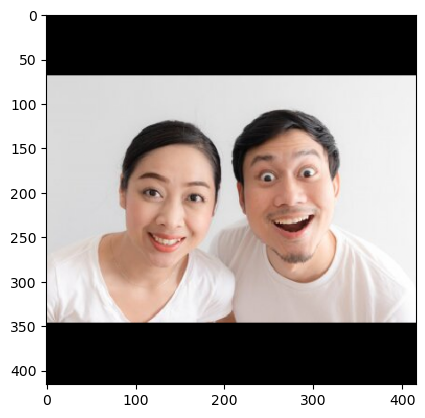

NMS
[tensor([[ 90.7468, 162.2692, 191.2896, 269.5879,   0.9866,   0.0000],
        [216.5130, 134.2191, 334.1328, 265.2646,   0.9796,   0.0000]])]
[tensor([[1.4102e+02, 2.1593e+02, 1.0054e+02, 1.0732e+02, 9.8686e-01, 9.9973e-01,
         2.4850e-04],
        [2.7532e+02, 1.9974e+02, 1.1762e+02, 1.3105e+02, 9.7979e-01, 9.9981e-01,
         1.0948e-04]], grad_fn=<IndexBackward0>)]
Face  0
tensor([1.4102e+02, 2.1593e+02, 1.0054e+02, 1.0732e+02, 9.8686e-01, 9.9973e-01,
        2.4850e-04], grad_fn=<UnbindBackward0>)
Cropped
90 162 192 270


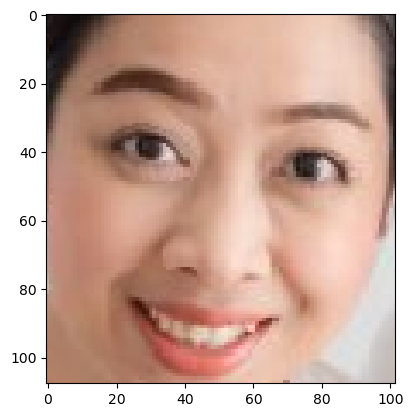

Resized


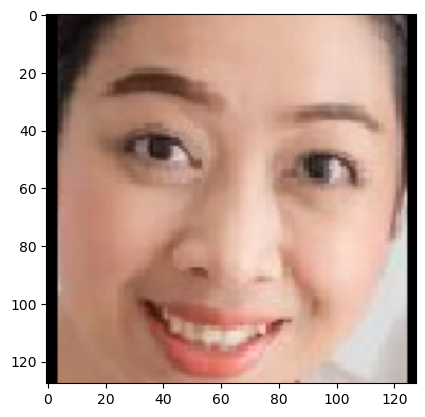

Gradient
torch.Size([1, 3, 416, 416])


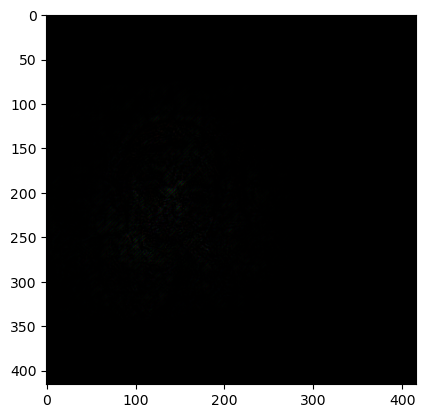

tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


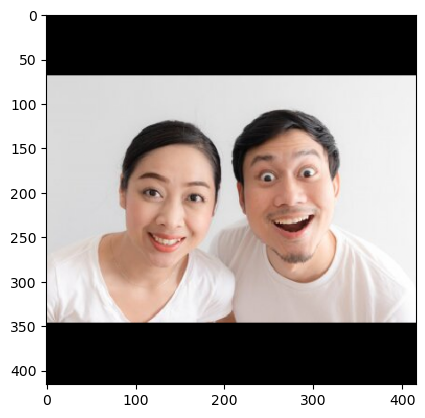

Face  1
tensor([2.7532e+02, 1.9974e+02, 1.1762e+02, 1.3105e+02, 9.7979e-01, 9.9981e-01,
        1.0948e-04], grad_fn=<UnbindBackward0>)
Cropped
216 134 335 266


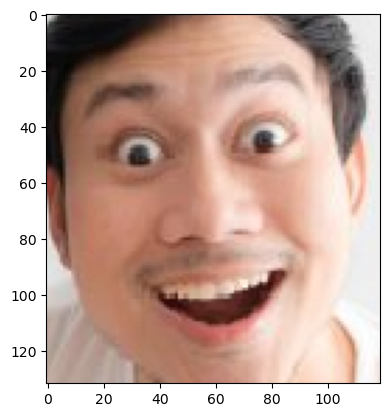

Resized


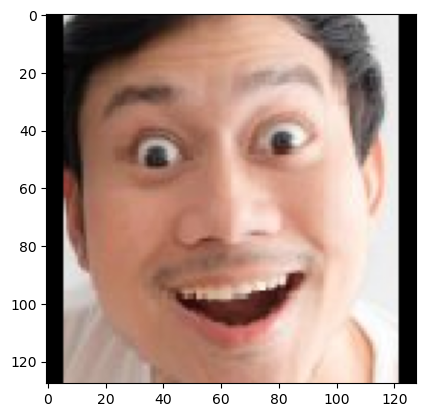

Gradient
torch.Size([1, 3, 416, 416])


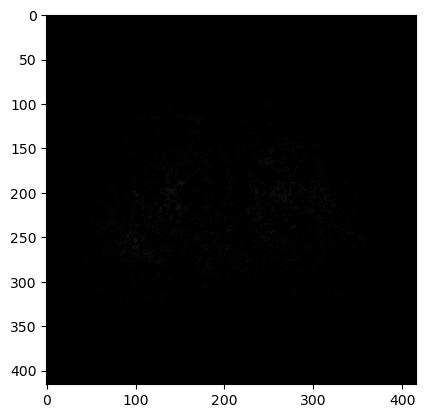

tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


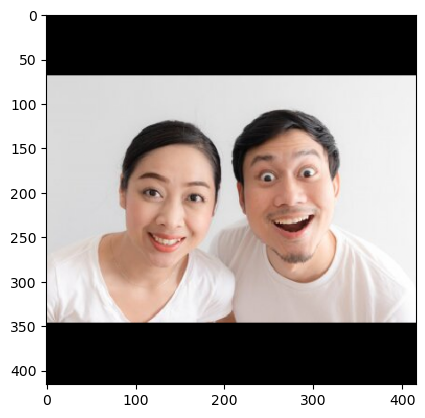

D:\Janjan Chua\Documents\GitHub\THS-ST1\images\girl.jpg
(6016, 4000, 3)
Input


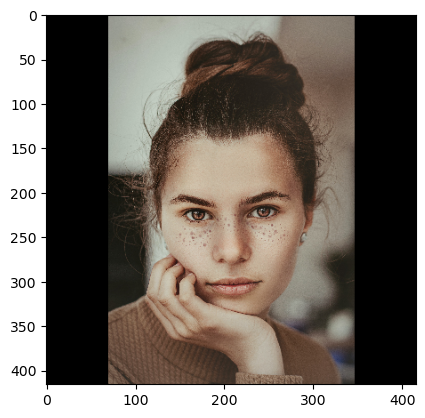

NMS
[tensor([[123.6825, 136.2603, 305.8475, 345.2425,   0.9956,   0.0000]])]
[tensor([[2.1476e+02, 2.4075e+02, 1.8216e+02, 2.0898e+02, 9.9574e-01, 9.9986e-01,
         1.3211e-04]], grad_fn=<IndexBackward0>)]
Face  0
tensor([2.1476e+02, 2.4075e+02, 1.8216e+02, 2.0898e+02, 9.9574e-01, 9.9986e-01,
        1.3211e-04], grad_fn=<UnbindBackward0>)
Cropped
123 136 306 346


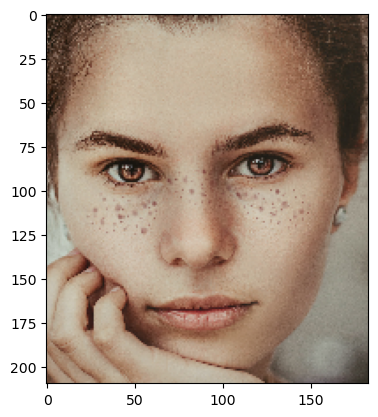

Resized


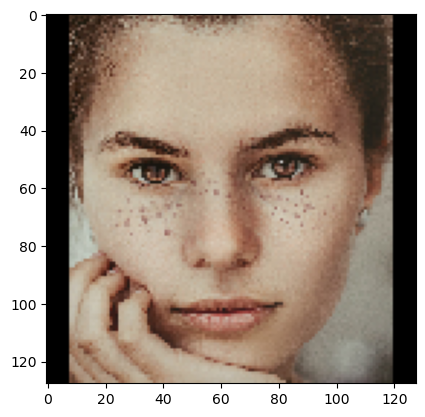

Gradient
torch.Size([1, 3, 416, 416])


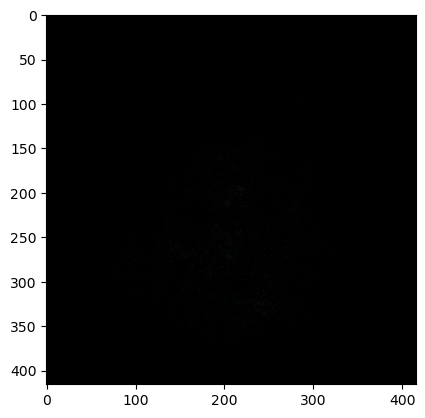

tensor(0., grad_fn=<MinBackward1>) tensor(0.8549, grad_fn=<MaxBackward1>)


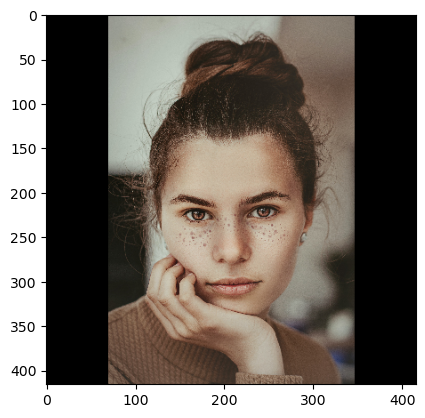

Epsilon 0.05
D:\Janjan Chua\Documents\GitHub\THS-ST1\images\couple.jpg
(267, 400, 3)
Input


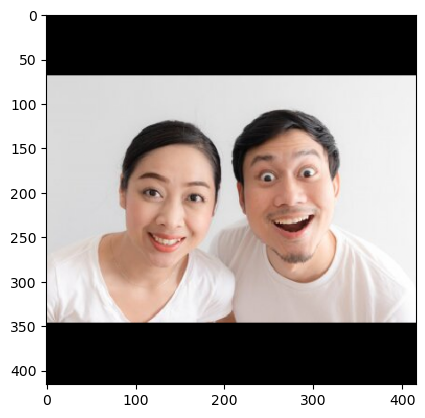

NMS
[tensor([[ 90.7468, 162.2692, 191.2896, 269.5879,   0.9866,   0.0000],
        [216.5130, 134.2191, 334.1328, 265.2646,   0.9796,   0.0000]])]
[tensor([[1.4102e+02, 2.1593e+02, 1.0054e+02, 1.0732e+02, 9.8686e-01, 9.9973e-01,
         2.4850e-04],
        [2.7532e+02, 1.9974e+02, 1.1762e+02, 1.3105e+02, 9.7979e-01, 9.9981e-01,
         1.0948e-04]], grad_fn=<IndexBackward0>)]
Face  0
tensor([1.4102e+02, 2.1593e+02, 1.0054e+02, 1.0732e+02, 9.8686e-01, 9.9973e-01,
        2.4850e-04], grad_fn=<UnbindBackward0>)
Cropped
90 162 192 270


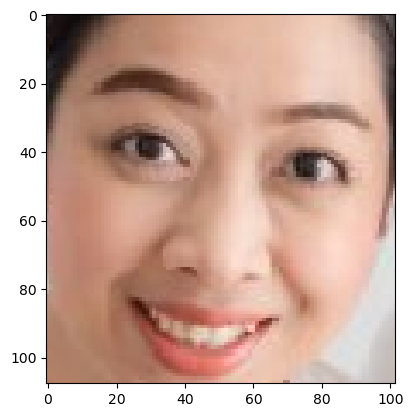

Resized


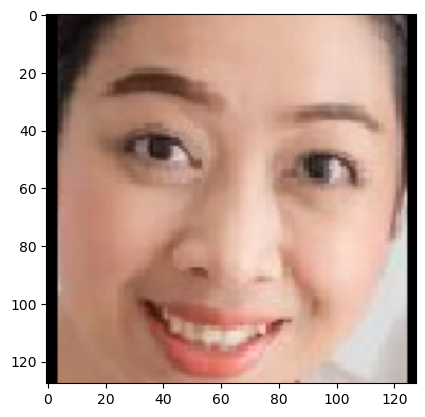

Gradient
torch.Size([1, 3, 416, 416])


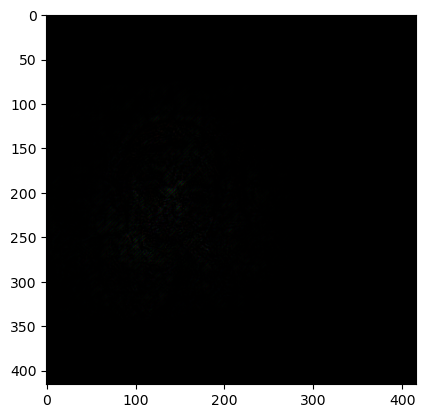

tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


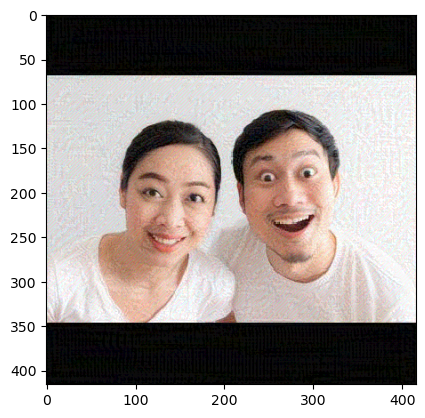

Face  1
tensor([2.7532e+02, 1.9974e+02, 1.1762e+02, 1.3105e+02, 9.7979e-01, 9.9981e-01,
        1.0948e-04], grad_fn=<UnbindBackward0>)
Cropped
216 134 335 266


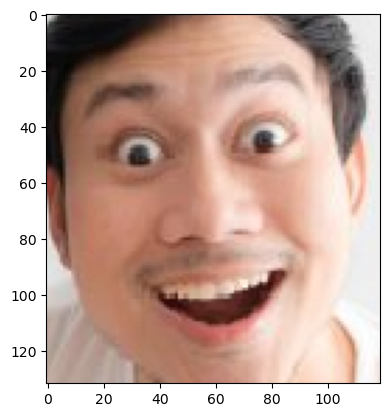

Resized


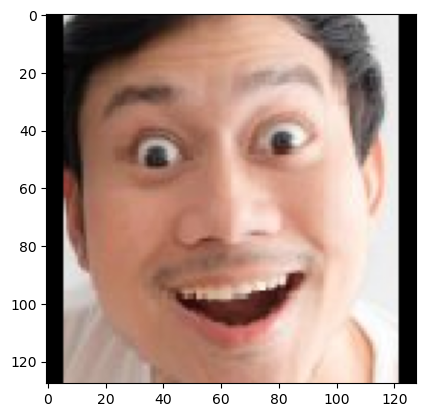

Gradient
torch.Size([1, 3, 416, 416])


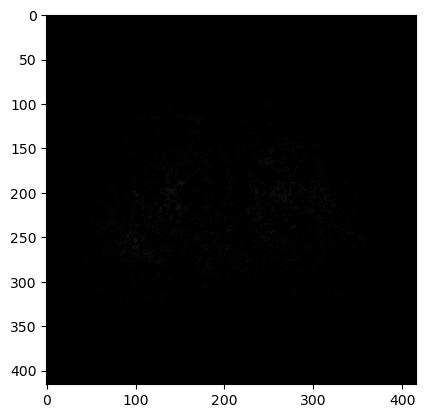

tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


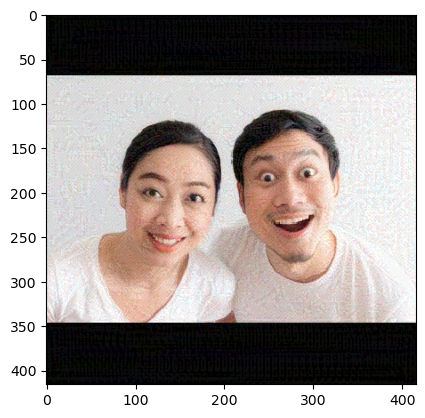

D:\Janjan Chua\Documents\GitHub\THS-ST1\images\girl.jpg
(6016, 4000, 3)
Input


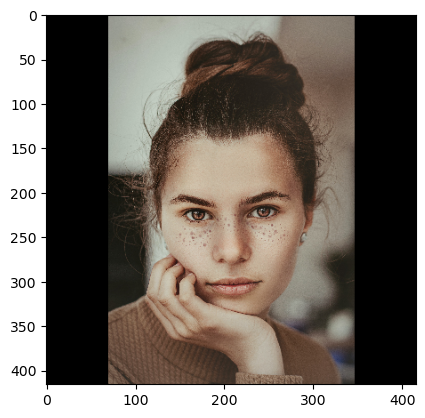

NMS
[tensor([[123.6825, 136.2603, 305.8475, 345.2425,   0.9956,   0.0000]])]
[tensor([[2.1476e+02, 2.4075e+02, 1.8216e+02, 2.0898e+02, 9.9574e-01, 9.9986e-01,
         1.3211e-04]], grad_fn=<IndexBackward0>)]
Face  0
tensor([2.1476e+02, 2.4075e+02, 1.8216e+02, 2.0898e+02, 9.9574e-01, 9.9986e-01,
        1.3211e-04], grad_fn=<UnbindBackward0>)
Cropped
123 136 306 346


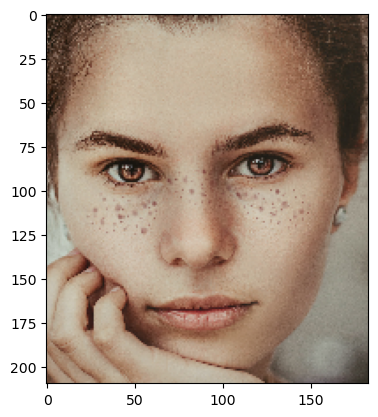

Resized


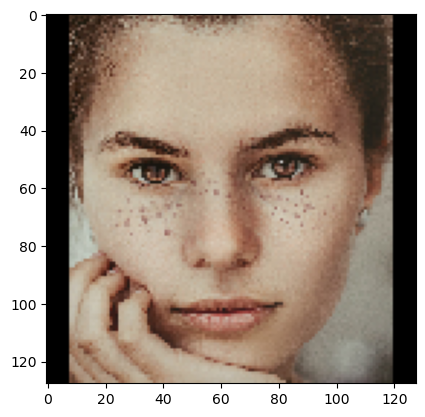

Gradient
torch.Size([1, 3, 416, 416])


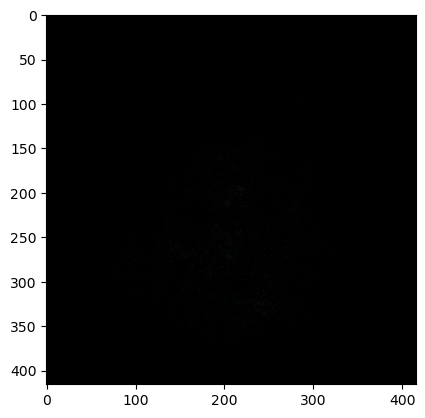

tensor(0., grad_fn=<MinBackward1>) tensor(0.9010, grad_fn=<MaxBackward1>)


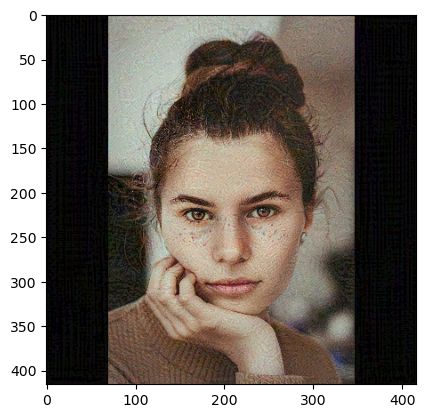

In [10]:
pipeline(model, device)